# $\mathrm{NOA}$ (nitrooxy-acetone)

In [1]:
using Pkg 
Pkg.activate("../")

  Activating project at `~/gitrepos/activepure/Photolysis.jl/mcm`


In [2]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 
using KernelFunctions
using ParameterHandling

In [3]:
include("./utils.jl")

filter_outliers (generic function with 1 method)

# Loading Data

In [4]:
h5_path = "../../data/photolysis_data.h5" 
species = "CH3C(O)CH2(ONO2)" 
nice_name = "nitrooxy-acetone"
λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

([245.0, 250.0, 255.0, 260.0, 265.0, 270.0, 275.0, 280.0, 285.0, 290.0  …  318.0, 320.0, 322.0, 324.0, 326.0, 328.0, 330.0, 332.0, 334.0, 336.0], [2.29e-19, 1.658e-19, 1.29e-19, 1.106e-19, 9.95e-20, 9.32e-20, 8.82e-20, 8.13e-20, 7.3e-20, 6.46e-20  …  1.24e-20, 1.04e-20, 8.6e-21, 7.06e-21, 5.73e-21, 4.6e-21, 3.65e-21, 2.87e-21, 2.23e-21, 1.71e-21], [298.0, 298.0, 298.0, 298.0], [NaN, NaN, NaN, NaN], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  4, 4, 4, 4, 4, 4, 4, 4, 4, 4], "K", "Organics (N-compounds)", "CH3C(O)CH2(ONO2)", "nm", "cm^2")

In [5]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 


In [6]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


In [7]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
println(nrow(df))
describe(df)

105


Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,λ,298.59,245.0,300.0,340.0,0,Float64
2,σ,4.24784e-20,1.58e-21,3.88e-20,2.29e-19,0,Float64
3,T,298.0,298.0,298.0,298.0,0,Float64
4,source_id,2.73333,1,3.0,4,0,Int64


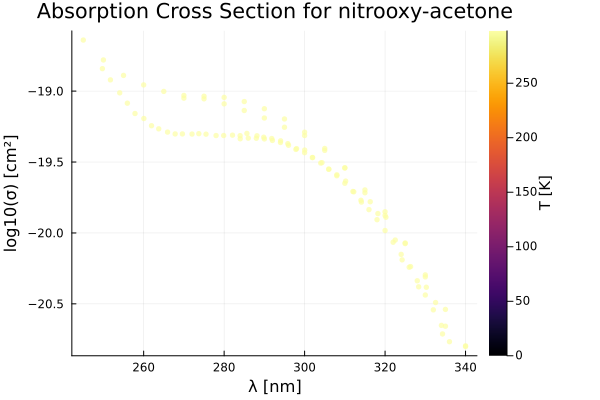

In [8]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)


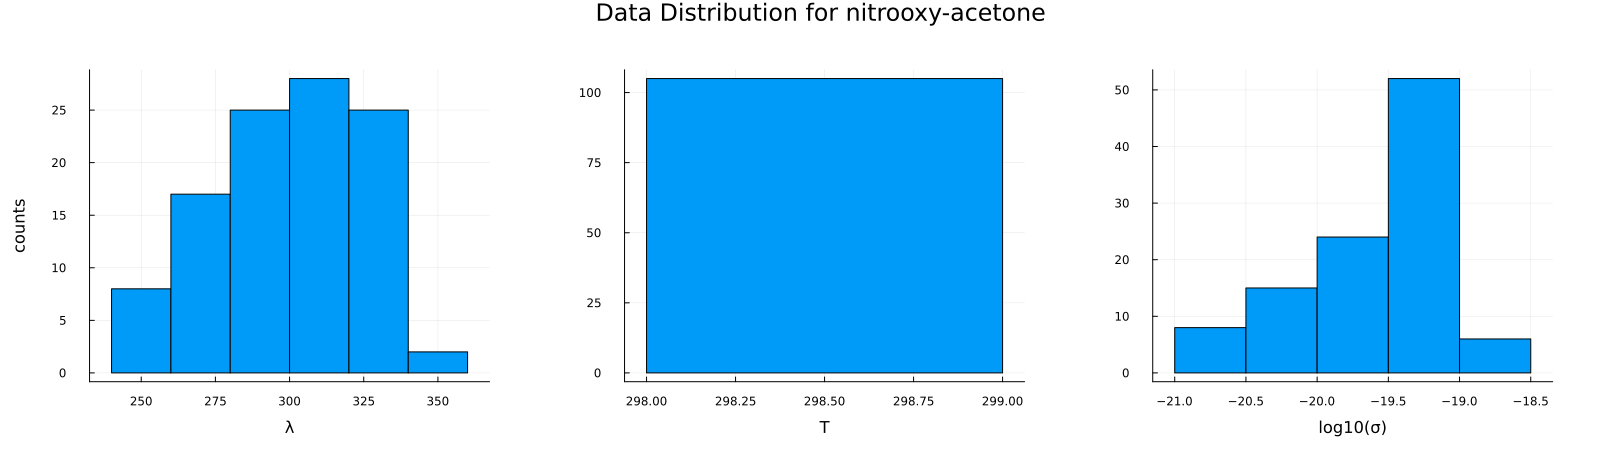

In [9]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Data Distribution for $(nice_name)")

In [10]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [11]:
println(nrow(hr4000_df))
println(maximum(hr4000_df.λ))
println(minimum(hr4000_df.λ))

3648
1120.216
194.249


# Data Preprocessing

In [12]:
gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

Row,λ,σ,T
,Float64,Float64,Float64
1,245.0,2.29e-19,298.0
2,250.0,1.658e-19,298.0
3,255.0,1.29e-19,298.0
4,260.0,1.106e-19,298.0
5,265.0,9.95e-20,298.0
6,270.0,9.12e-20,298.0
7,275.0,9.01e-20,298.0
8,280.0,8.58e-20,298.0
9,285.0,7.87e-20,298.0


In [13]:
df_unique = filter_outliers(df_unique, log10.(df_unique.σ))
println(nrow(df_unique))

# df_unique = df_unique[df_unique.T .!= 298.0, :]

82


In [14]:
λ_idxs = representative_rand_sample(df_unique.λ, 1000, 2000)
T_idxs = representative_rand_sample(df_unique.λ, 5, 500)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 

idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs,σ_idxs)))


df_sampled = df_unique[idxs_res, :]

println(size(df_sampled))

max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

(82, 3)


245.0

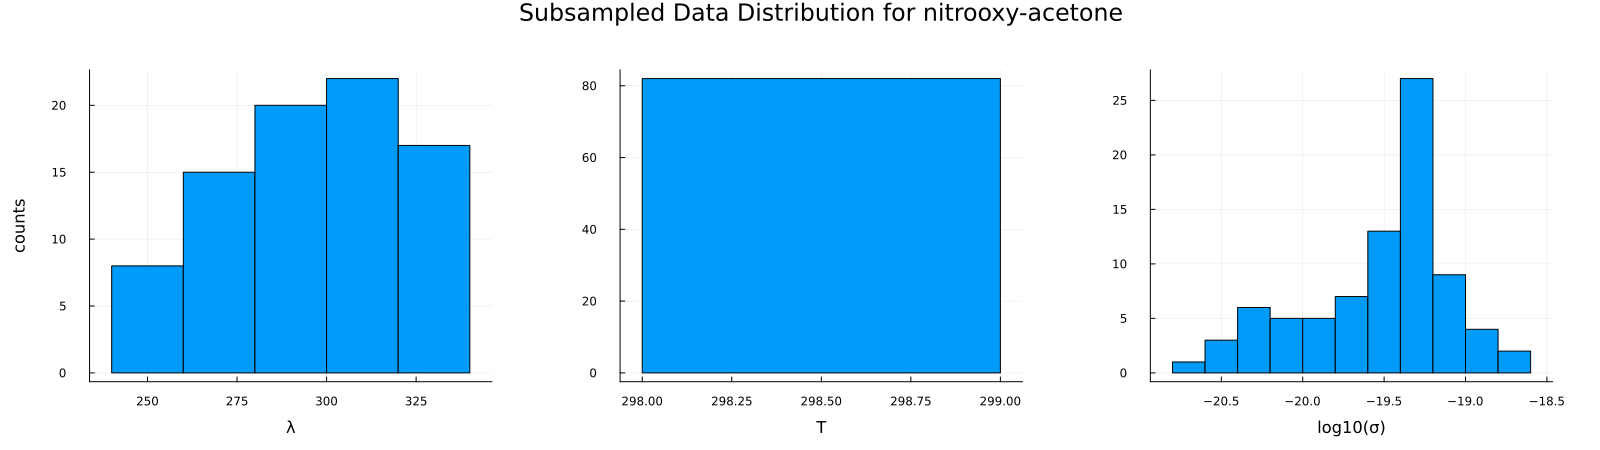

In [15]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

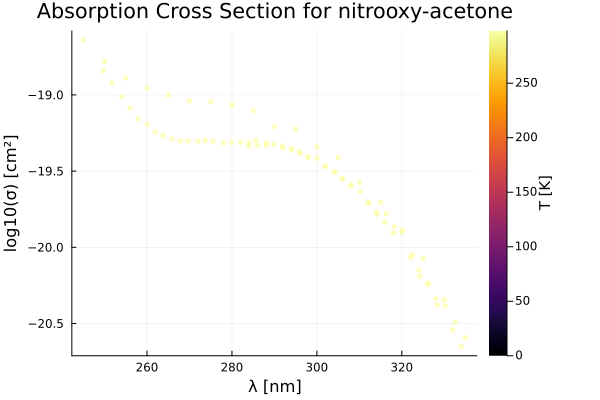

In [16]:
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [17]:
train_frac = 0.9
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

73


In [18]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

9-element Vector{Float64}:
 -19.24412514432751
 -19.334419008982046
 -19.30189945437661
 -19.002176919254275
 -19.468521082957746
 -20.65169513695184
 -18.84163750790475
 -19.55129368009492
 -19.899629454882437

In [19]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
# ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
# SNR = 10
σf² = 40.0 #var(ytrain)
σₙ² = 0.1 #(sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ)) # , ℓ_T=positive(ℓ_T))

# replacing with previously found best-fit values
θ_init = (σf²=positive(123.13369490006616), ℓ_λ=positive(76.29587903764445)) # , ℓ_T=positive(ℓ_T))
σₙ² = 0.005430704648519605

function mykernel(θ::NamedTuple)
    # return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ,])
end

mykernel (generic function with 1 method)

In [20]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)

GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.813270715355564, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(4.334618926644958, exp, 1.4901161193847656e-8)), 
  σ² = 0.005430704648519605, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [21]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0    -6.728329e+01     1.356122e+00
 * time: 0.030141115188598633
     1    -6.730428e+01     7.125171e-01
 * time: 0.9478869438171387
     2    -6.731253e+01     9.572156e-02
 * time: 0.9517021179199219
     3    -6.731717e+01     2.102177e-02
 * time: 0.9597699642181396
     4    -6.731717e+01     2.492132e-03
 * time: 0.9632658958435059
     5    -6.731717e+01     8.565680e-05
 * time: 0.9670190811157227
     6    -6.731717e+01     1.529263e-07
 * time: 0.9707889556884766
     7    -6.731717e+01     2.295469e-09
 * time: 0.9759080410003662


trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @314 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @604 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [22]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [4.713967876625871, 4.315527506276409, -5.256786082350464],
 minimum = -67.31717463455348,
 iterations = 7,
 converged = true,)

In [23]:
fp = fitted_params(mach)

(θ_best = [:σf² => 111.4936765526334, :ℓ_λ => 74.853098525529],
 σ² = 0.005212043762008715,)

In [24]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

now let's collect some more points in order to evaluate our model using indices other than the ones used during training. 


┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


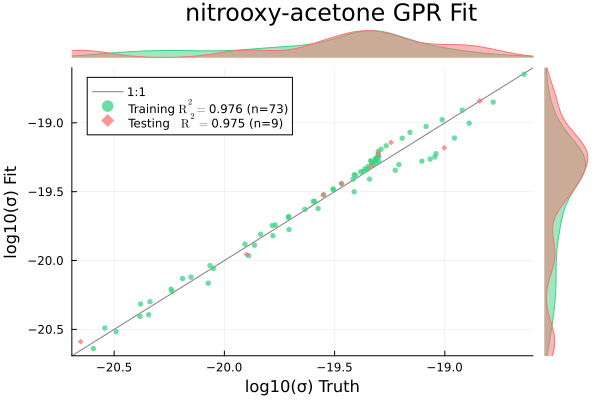

In [25]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)


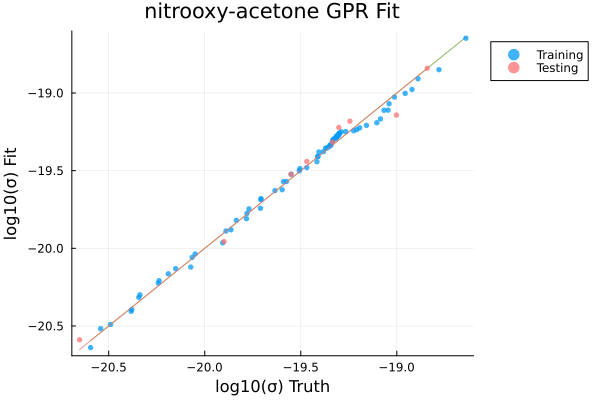

In [26]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


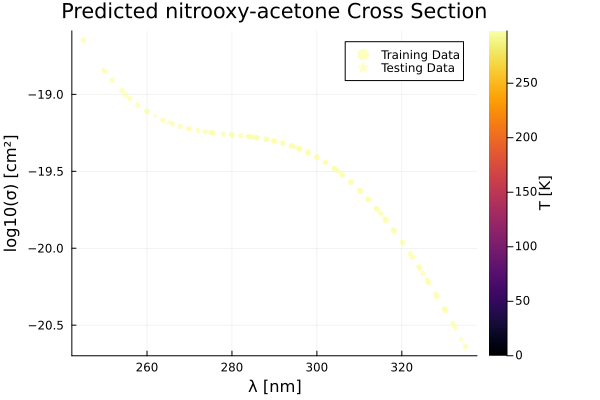

In [27]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)


Finally, let's try prediction at the desired wavelength bins: 

245.0
335.0


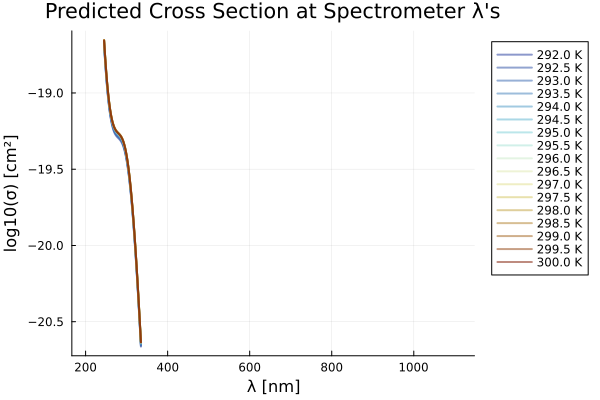

In [28]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

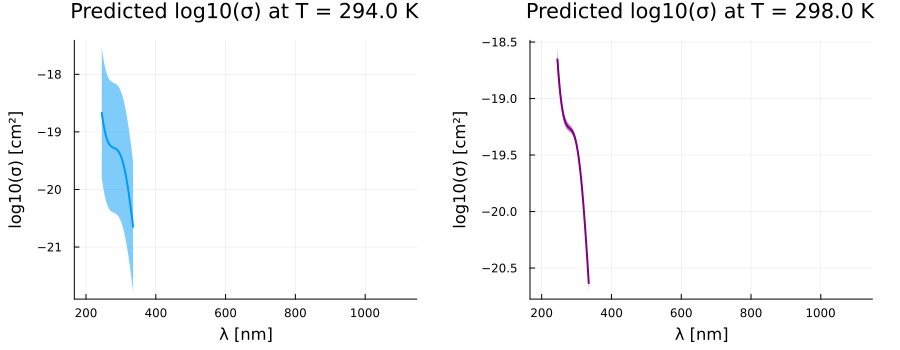

In [29]:
Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 

# Output for Photolysis Rate Determination

In [30]:
df_photolysis_σ = CSV.File("../photolysis_σ.csv") |> DataFrame 

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64
9,σ_8,8.92125e-20,0.0,0.0,1.11355e-17,0,Float64


In [31]:
λ_min = minimum(df_sampled.λ)
λ_max = maximum(df_sampled.λ)

println(λ_min, "\t", minimum(df_photolysis_σ.λ))
println(λ_max, "\t", maximum(df_photolysis_σ.λ))

245.0	194.249
335.0	1120.216


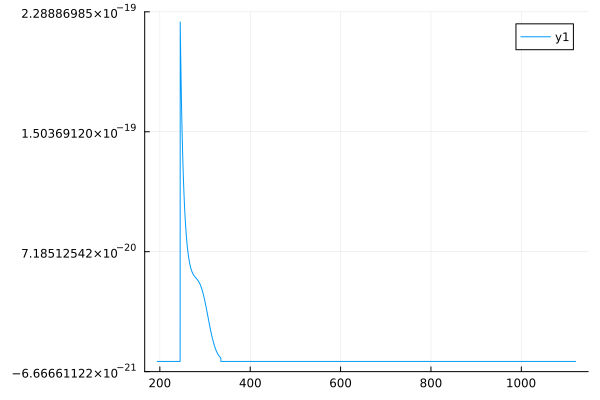

In [32]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

σ = 10 .^ logσ

replace!(σ, NaN => 0.0)

# set anything outside of λ range to 0 as well
σ[hr4000_df.λ .< λ_min .|| hr4000_df.λ .> λ_max] .= 0.0


plot(hr4000_df.λ, σ)

In [33]:
df_photolysis_σ.σ_56 = σ

describe(df_photolysis_σ)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,λ,667.499,194.249,672.636,1120.22,0,Float64
2,σ_1,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
3,σ_2,5.26742e-19,0.0,2.82646e-22,1.17236e-17,0,Float64
4,σ_3,2.15632e-20,0.0,0.0,7.82292e-19,0,Float64
5,σ_4,1.25113e-19,0.0,6.4171e-21,6.41009e-19,0,Float64
6,σ_5,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
7,σ_6,6.58792e-19,0.0,1.71951e-28,1.5094e-17,0,Float64
8,σ_7,8.4788e-20,0.0,0.0,2.33417e-18,0,Float64
9,σ_8,8.92125e-20,0.0,0.0,1.11355e-17,0,Float64


In [34]:
CSV.write("../photolysis_σ.csv", df_photolysis_σ)

"../photolysis_σ.csv"